In [45]:
import tensorflow as tf
from tensorflow.contrib import seq2seq
import time
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt
import pandas as pd
import pickle

In [39]:
data = pd.read_csv('EURUSD.txt')

In [40]:
data.head()

,<TICKER>,<DTYYYYMMDD>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,EURUSD,20010102,230100,0.9507,0.9507,0.9507,0.9507,4
1,EURUSD,20010102,230200,0.9506,0.9506,0.9505,0.9505,4
2,EURUSD,20010102,230300,0.9505,0.9507,0.9505,0.9506,4
3,EURUSD,20010102,230400,0.9506,0.9506,0.9506,0.9506,4
4,EURUSD,20010102,230500,0.9506,0.9506,0.9506,0.9506,4


In [41]:
data.tail()

,<TICKER>,<DTYYYYMMDD>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
5754827,EURUSD,20170531,235500,1.1238,1.1238,1.1238,1.1238,4
5754828,EURUSD,20170531,235600,1.1237,1.1237,1.1237,1.1237,4
5754829,EURUSD,20170531,235700,1.1237,1.1237,1.1237,1.1237,4
5754830,EURUSD,20170531,235800,1.1237,1.1237,1.1237,1.1237,4
5754831,EURUSD,20170531,235900,1.1238,1.1238,1.1238,1.1238,4


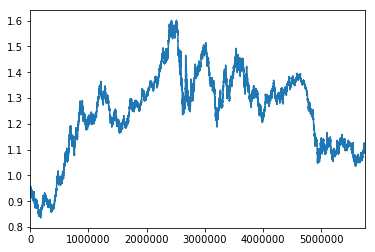

In [29]:
data_sub = data[data['<TIME>']%10000 == 0]['<OPEN>']
data_sub.plot()
plt.show()
del data

In [23]:
data_sub.shape

(96354,)

In [33]:
data_open = np.array(data_sub)
del data_sub

NameError: name 'data_sub' is not defined

In [34]:
def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

In [35]:
def data_prepare(data, seq_len, normalise_window):
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)

    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

In [36]:
x_train, y_train, x_test, y_test =  data_prepare(data_open, 50, False)

In [37]:
x_train.shape

(86673, 50, 1)

In [96]:
num_epochs = 1
batch_size = 256
lstm_layers = 2
rnn_size = 256
seq_length = 50
keep_prob = 0.5
learning_rate = 0.01
show_every_n_batches = 100
save_dir = './save'

In [103]:
inputs = tf.placeholder(tf.float32, [batch_size, seq_length, 1], name='input')
target = tf.placeholder(tf.float32, [batch_size, 1], name='target')
learning_rate = tf.placeholder(tf.float32, name='learning_rate')
lstm = tf.contrib.rnn.BasicLSTMCell(rnn_size)
drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob)
cell = tf.contrib.rnn.MultiRNNCell([lstm] * lstm_layers)
initial_state = tf.identity(cell.zero_state([lstm_layers, batch_size, rnn_size], tf.float32), name='initial_state')
outputs, output_state = tf.nn.dynamic_rnn(cell, inputs, initial_state=initial_state)
final_state = tf.identity(output_state, name='final_state')
logits = tf.contrib.layers.fully_connected(outputs, 1, activation_fn = None,
                                            weights_initializer=tf.truncated_normal_initializer(stddev=0.01))
optimizer = tf.train.AdamOptimizer(lr)
gradients = optimizer.compute_gradients(cost)
capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients]
train_op = optimizer.apply_gradients(capped_gradients)

ValueError: Shapes must be equal rank, but are 1 and 0
	From merging shape 0 with other shapes. for 'MultiRNNCellZeroState_41/BasicLSTMCellZeroState/stack_1' (op: 'Pack') with input shapes: [3], [].

In [91]:
from tensorflow.python.util import nest

In [93]:
help(nest.is_sequence)

Help on function is_sequence in module tensorflow.python.util.nest:

is_sequence(seq)
    Returns a true if its input is a collections.Sequence (except strings).
    
    Args:
      seq: an input sequence.
    
    Returns:
      True if the sequence is a not a string and is a collections.Sequence.



In [94]:
collections.Sequence

NameError: name 'collections' is not defined